In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Raúl
import pandas as pd # Estructura y manipulación de datos
url='/content/drive/MyDrive/Machine Learning/Prueba 2/Anexo ET_demo_round_traces_2022.csv'
df = pd.read_csv(url, sep=";", encoding='utf-8')


/tmp/ipython-input-2-705487826.py:4: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=";", encoding='utf-8')


In [ ]:
#Sofia
url = '/content/drive/MyDrive/Fundamentos de machine learning/Anexo ET_demo_round_traces_2022.csv'
df = pd.read_csv(url, sep=";", encoding='utf-8')


In [3]:
#Con esta linea de codigo podemos asegurarnos de que las variables a utilizar sean numericas
df['MatchAssists'] = pd.to_numeric(df['MatchAssists'], errors='coerce')
df['TimeAlive'] = pd.to_numeric(df['TimeAlive'], errors='coerce')
df['MatchHeadshots'] = pd.to_numeric(df['MatchHeadshots'], errors='coerce')
df['RoundKills'] = pd.to_numeric(df['RoundKills'], errors='coerce')

In [4]:
# 3.1. Imputar NaN en columnas numéricas usando la media
import numpy as np # Programación vectorial
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    if df[col].isnull().sum() > 0:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

/tmp/ipython-input-4-1837726787.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [5]:
# 3.2.En columnas categóricas rellenamos con el valor más frecuente
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

/tmp/ipython-input-5-3727136605.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)
/tmp/ipython-input-5-3727136605.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(mode_value, inplace=True)


In [6]:
# 1. Filtrar datos válidos
df['RoundWinner'] = df['RoundWinner'].astype(str).str.strip()
df = df[df['RoundWinner'].isin(['True', 'False'])].copy()
df['RoundWinner'] = df['RoundWinner'].map({'True': 1, 'False': 0})
df = df[df['AbnormalMatch'] == False]

# 2. Definir variables a agregar (sin RoundWinner porque no vamos a sumarla)
variables_a_agregar = {
    'RoundKills': 'sum',
    'RoundAssists': 'sum',
    'RoundHeadshots': 'sum',
    'RoundFlankKills': 'sum',
    'TimeAlive': 'mean',
    'RLethalGrenadesThrown': 'sum',
    'RNonLethalGrenadesThrown': 'sum',
    'RoundStartingEquipmentValue': 'mean',
}

# 3. Agrupar por MatchId y aplicar agregaciones
df_partida_agregado = df.groupby('MatchId').agg(variables_a_agregar).reset_index()

# 4. Renombrar columnas
df_partida_agregado = df_partida_agregado.rename(columns={
    'RoundKills': 'TotalKills',
    'RoundAssists': 'TotalRoundAssists_by_Match',
    'RoundHeadshots': 'TotalRoundHeadshots_by_Match',
    'RoundFlankKills': 'TotalRoundFlankKills_by_Match',
    'TimeAlive': 'TimeAlive_by_Match',
    'RLethalGrenadesThrown': 'TotalLethalGrenades_by_Match',
    'RNonLethalGrenadesThrown': 'TotalNonLethalGrenades_by_Match',
    'RoundStartingEquipmentValue': 'RoundEquipmentValue_by_Match',
})

# 5. Traer info del nivel partido y convertir MatchWinner a 0/1
df_info_partida = df[['MatchId', 'MatchWinner', 'Map', 'Team', 'AbnormalMatch']].drop_duplicates(subset=['MatchId']).copy()
df_info_partida['MatchWinner'] = df_info_partida['MatchWinner'].map({True:1, False:0})

# 6. Merge de los datos agregados con info del partido
df_final_partida = pd.merge(df_partida_agregado, df_info_partida, on='MatchId', how='left')

# 7. Ingeniería de características
df_final_partida['MatchValue'] = (df_final_partida['TotalKills'] +
                                 df_final_partida['TotalRoundAssists_by_Match'] +
                                 df_final_partida['TotalRoundFlankKills_by_Match'])
df_final_partida['MatchEfficencie'] = df_final_partida['TotalKills'] / (df_final_partida['TimeAlive_by_Match'] + 1)
df_final_partida['GrenadesImpact'] = (df_final_partida['TotalLethalGrenades_by_Match'] +
                                     df_final_partida['TotalNonLethalGrenades_by_Match'])

# 8. Selección de variables y target
X = df_final_partida[[
    'TotalRoundAssists_by_Match',
    'TotalRoundHeadshots_by_Match',
    'TimeAlive_by_Match',
    'MatchValue',
    'MatchEfficencie',
    'GrenadesImpact'
]].copy()

y = df_final_partida['MatchWinner']

print("Filas en X:", X.shape[0])
print("Filas en y:", y.shape[0])
print("¿Hay valores nulos en X?", X.isnull().any().any())
print("¿Hay valores nulos en y?", y.isnull().any())

# 9. División en entrenamiento y prueba (con stratify para mantener proporción)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Filas en X: 333
Filas en y: 333
¿Hay valores nulos en X? False
¿Hay valores nulos en y? False


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train, y_train)

# Realizar predicciones
y_pred = modelo_log.predict(X_test)

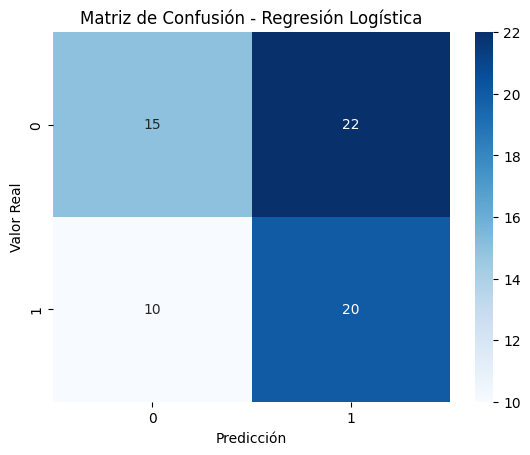

              precision    recall  f1-score   support

           0       0.60      0.41      0.48        37
           1       0.48      0.67      0.56        30

    accuracy                           0.52        67
   macro avg       0.54      0.54      0.52        67
weighted avg       0.54      0.52      0.52        67



In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# Reporte de métricas
print(classification_report(y_test, y_pred))

Precision clase 0 (derrota): el modelo predice derrota correctamente el 60% de las veces que lo intenta, pero se equivoca más de lo deseado.

Recall clase 0 (derrota): solo detecta correctamente el 41% de las derrotas reales → alto número de falsos negativos.

Precision clase 1 (victoria): acierta el 48% de las veces cuando predice victoria → no muy confiable.

Recall clase 1 (victoria): 67% de las victorias reales son correctamente clasificadas → mejor desempeño que la clase 0 en este aspecto.

La exactitud general del modelo (52%) es baja, apenas por encima del azar si las clases estuvieran balanceadas.

El modelo de regresión logística no captura bien la relación entre las variables predictoras y la victoria.

Parece que el problema tiene una naturaleza no lineal, y por eso XGBoost funcionó mejor antes (60% de accuracy vs 52% acá).

